# Pricing Analysis

#### Objective
This project's objective is to analyze the pricing of some products and determine if they are priced correctly. Furthermore, we aim to show what is the best price for each product.

#### Tools
`Pandas`, `Numpy`, `PyGAM`, `StatsModels`, `Scikit-Learn`, `ggplot`.

## Imports

In [1]:
# Data Wrangling
import pandas as pd
import numpy as np

# Data Visualization
from plotnine import *
import plotly_express as px

# Modeling
from sklearn.preprocessing import LabelEncoder
from pygam import GAM, ExpectileGAM, s, l, f
import statsmodels.api as sm

import warnings
warnings.simplefilter('ignore')

## Load Data

In [255]:
# load dataset
file_ = '../.data/financial_sample2.xlsx'
df = pd.read_excel(file_)

print(f'Data Shape: {df.shape}')

# View data head
df.sample(3)

Data Shape: (2800, 10)


,Segment,Product,discount,Quantity,price,Sales,Date,mth_num,mth_name,yr
1398,Government,Paseo,Medium,348,40.035304,13932.285810,2013-11-01,11,November,2013
1276,Enterprise,Paseo,High,383,38.270576,14657.630420,2014-10-01,10,October,2014
2732,Enterprise,VTT,Low,317,18.447380,5847.819472,2014-06-01,6,June,2014


In [224]:
df.dtypes

Segment             object
Product             object
discount            object
Quantity             int64
price              float64
Sales              float64
Date        datetime64[ns]
mth_num              int64
mth_name            object
yr                   int64
dtype: object

In [225]:
# There are NAs only in `discount`, when there is no discount.
# We will replace those NAs with "No Discount"
df.fillna("No Discount", inplace=True)

In [ ]:
# Statistical description
df.describe(include='all').T

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
Segment,2800,5,Government,1200,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Product,2800,6,Paseo,808,NaN,NaN,NaN,NaN,NaN,NaN,NaN
discount,2588,3,High,980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Quantity,2800.0,NaN,NaN,NaN,1257.612857,145.0,346.0,646.5,1092.5,10747.0,1845.44054
price,2800.0,NaN,NaN,NaN,22.576275,1.0,9.440982,18.529493,37.216872,51.97611,14.726118
Sales,2800.0,NaN,NaN,NaN,23425.440908,889.086541,5877.163996,10799.78575,19202.839728,434075.8931,45081.43012
Date,2800,NaN,NaN,NaN,2014-04-28 21:36:00,2013-09-01 00:00:00,2013-12-24 06:00:00,2014-05-16 12:00:00,2014-09-08 12:00:00,2014-12-01 00:00:00,NaN
mth_num,2800.0,NaN,NaN,NaN,7.9,1.0,5.75,9.0,10.25,12.0,3.37551
mth_name,2800,12,October,560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
yr,2800.0,NaN,NaN,NaN,2013.75,2013.0,2013.75,2014.0,2014.0,2014.0,0.43309


* No major concerns, no apparent errors in the data.
* The biggest variance is in Sales numbers.

## Exploratory Analysis

In [227]:
# Exploring the relationship between price and units sold
fig = px.scatter(
    df, 
    x= 'price', y = 'Quantity',
    color= 'Product',
    opacity=0.5,
    trendline='lowess',
    # trendline_color_override='blue',
    title= 'Price vs Quantity Analysis',
    width=900,
    height=500,
    color_discrete_sequence=px.colors.qualitative.G10
).update_traces(
    marker= dict(size=7),
    hoverlabel= dict(font= dict(size=10))
).update_xaxes(
    title_text = 'Price',
    tickfont= dict(size=10)
).update_yaxes(
    title_text = 'Quantity Sold',
    tickfont= dict(size=10)
)

# Show figure
fig

In [228]:
# Exploring the relationship between price and units sold conditioned on the Discounts
fig = px.scatter(
    df, 
    x= 'price', y = 'Quantity',
    color= 'discount',
    facet_col= 'Product',
    facet_col_wrap=2,
    facet_col_spacing=0.1,
    facet_row_spacing=0.15,
    opacity=0.5,
    trendline='lowess',
    title= 'Price vs Quantity | Discount Analysis',
    width=1000,
    height=800,
    color_discrete_sequence=px.colors.qualitative.G10
).update_traces(
    marker= dict(size=7),
    hoverlabel= dict(font= dict(size=10))
).update_xaxes(
    title_text = 'Price',
    tickfont= dict(size=10)
).update_yaxes(
    title_text = 'Quantity Sold',
    tickfont= dict(size=10)
)

fig.for_each_yaxis(lambda yaxis: yaxis.update(showticklabels=True))
fig.for_each_xaxis(lambda xaxis: xaxis.update(showticklabels=True))

# Show figure
fig

## Modeling Event Impact

In [229]:
# Encoding the data
df_encoded = df.copy()

# One Hot Encoding the events and products
df_encoded = pd.get_dummies(df_encoded,
                            columns= ['discount', 'Product'],
                            drop_first=False)

# Get column names Events
colnames_event = df_encoded.columns[df_encoded.columns.str.startswith('discount')].tolist()
# From boolean to integer
df_encoded[colnames_event] = df_encoded[colnames_event].astype(int)

# Get column names Products
colnames_product = df_encoded.columns[df_encoded.columns.str.startswith('Product')].tolist()
# From boolean to integer
df_encoded[colnames_product] = df_encoded[colnames_product].astype(int)


In [230]:
# X & y for modeling
X = df_encoded[['price'] + colnames_event + colnames_product]
X = sm.add_constant(X) # adding intercept
y = df_encoded['Quantity']

# Model Fit
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               Quantity   R-squared:                       0.298
Model:                            OLS   Adj. R-squared:                  0.295
Method:                 Least Squares   F-statistic:                     131.3
Date:                Tue, 04 Feb 2025   Prob (F-statistic):          1.48e-206
Time:                        12:59:45   Log-Likelihood:                -24535.
No. Observations:                2800   AIC:                         4.909e+04
Df Residuals:                    2790   BIC:                         4.915e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  910.2506 

In [231]:
# Getting the Effects (parameters) from each variable
params_df = pd.DataFrame(model.params).T
params_df

,const,price,discount_High,discount_Low,discount_Medium,discount_No Discount,Product_Amarilla,Product_Carretera,Product_Montana,Product_Paseo,Product_VTT,Product_Velo
0,910.250587,-13.726489,1770.507958,-390.762501,-16.79389,-452.700979,93.316475,185.416509,66.528296,248.355448,0.109143,316.524716


In [232]:
# Estimating the price effects ratio
(params_df['discount_High'] + params_df['const']) / (params_df['discount_No Discount'] + params_df['const'])

0    5.858946
dtype: float64

The effect of the *High* price discount is approximatelly **6 times** higher than the prices with *No discount*.

In [233]:
(params_df['discount_High'] + params_df['const'])

0    2680.758545
dtype: float64

In [234]:
(params_df['discount_No Discount'] + params_df['const'])

0    457.549608
dtype: float64

## Modeling with GAM

GAM (Generalized Additive Model) is an additive modeling technique where the impact of the predictive variables is captured through smooth functions.

In [246]:
# Filtering data
data_filtered = df.query('discount == "No Discount"')

# List of products in our data
unique_prod = data_filtered['Product'].unique()

# Create an empty dataframe to store results
all_gam_results = pd.DataFrame()

In [247]:
# Loop through products
for product in unique_prod:
    # Filter for current product
    product_data = data_filtered.query('Product == @product')

    # Predictors & target split
    X = product_data[['price']]
    y = product_data['Quantity']

    # List of quantiles for modeling
    quantiles = [0.025, 0.5, 0.975]
    gam_results = {}

    # Fit the GAM model
    for q in quantiles:
        gam = ExpectileGAM(s(0), expectile=q) # instance the model
        gam.fit(X,y) #fit
        gam_results[f'pred_{q}'] = gam.predict(X) #predict for that quantile

    # Store the results in a DF
    predictions_gam = pd.DataFrame(gam_results).set_index(X.index)

    # Concatenate results column-wise with the original data
    predictions_gam_df = pd.concat([product_data[['price', 'Product','Quantity']], predictions_gam], axis=1)
    
    # Concatenate results row-wise
    all_gam_results = pd.concat([all_gam_results, predictions_gam_df], axis=0)

In [248]:
all_gam_results.sample(5)

,price,Product,Quantity,pred_0.025,pred_0.5,pred_0.975
2781,24.569622,VTT,195,167.103414,189.490769,223.402745
2334,34.193691,Velo,197,199.148993,214.162027,272.687898
699,19.530485,Carretera,286,214.020078,246.889700,284.918030
1110,16.129884,Montana,223,214.481237,231.283750,282.884993
367,13.107931,Amarilla,234,222.014716,256.931525,302.664877


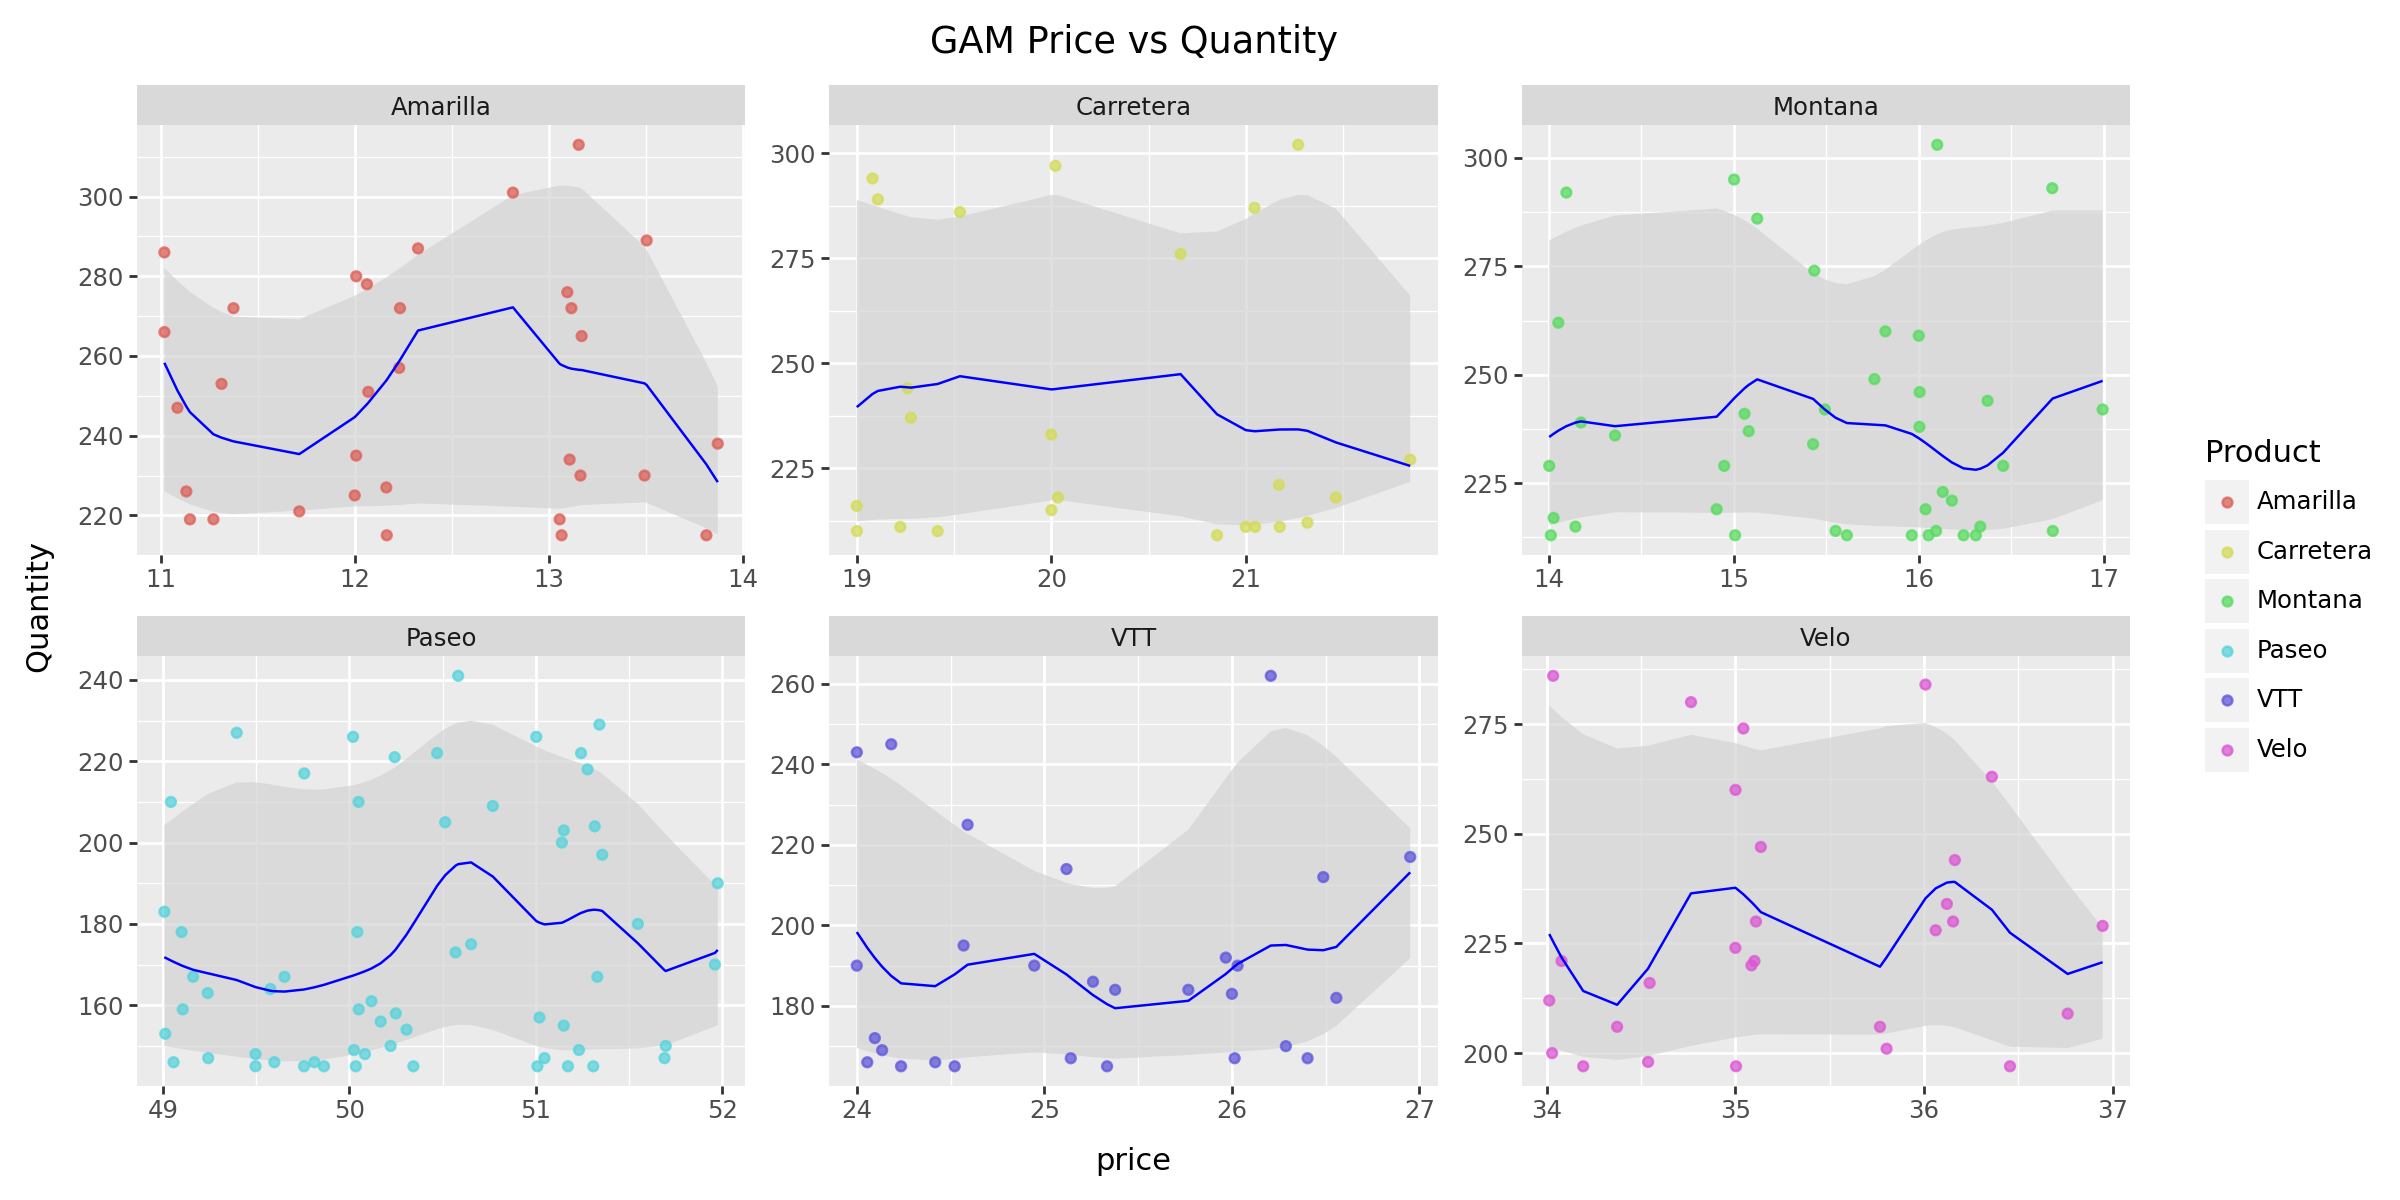

In [253]:
# Visualization
(ggplot(
    data = all_gam_results,
    mapping = aes(x='price', y='Quantity', color='Product', group= 'Product') ) +
    geom_ribbon(aes(ymax= 'pred_0.975', ymin= 'pred_0.025'), 
                fill='#d3d3d3', color= '#FF000000', alpha=0.7, show_legend=False) +
    geom_point(alpha=0.75) + 
    geom_line(aes(y='pred_0.5'), color='blue') +
    facet_wrap('Product', scales='free') + 
    labs(title='GAM Price vs Quantity') +
    theme(figure_size=(12,6))
)

### Optimize Price

In [250]:
# Calculate Revenue for each predicted price band
for col in all_gam_results.columns:
    if col.startswith('pred'):
        all_gam_results['revenue_' + col] = all_gam_results['price'] * all_gam_results[col]

# Actual revenue
all_gam_results['revenue_actual'] = all_gam_results['price'] * all_gam_results['Quantity']

# View
all_gam_results.sample(2)


,price,Product,Quantity,pred_0.025,pred_0.5,pred_0.975,revenue_pred_0.025,revenue_pred_0.5,revenue_pred_0.975,revenue_actual
2772,24.000219,VTT,190,169.540242,198.347792,241.260663,4069.002969,4760.390472,5790.308776,4560.041641
1087,15.001707,Montana,295,218.208299,244.546392,286.879106,3273.496886,3668.613227,4303.676178,4425.503447


In [251]:
# Calculating where the predicted median revenue is the max
best_50 = (
    all_gam_results
    .groupby('Product')
    .apply(lambda x: x[x['revenue_pred_0.5'] == x['revenue_pred_0.5'].max()].head(1))
    .reset_index(level=0, drop=True)
)

# Calculating where the predicted 97.5% percentile revenue is the max
best_975 = (
    all_gam_results
    .groupby('Product')
    .apply(lambda x: x[x['revenue_pred_0.975'] == x['revenue_pred_0.975'].max()].head(1))
    .reset_index(level=0, drop=True)
)

# Calculating where the predicted 2.5% percentile revenue is the max
best_025 = (
    all_gam_results
    .groupby('Product')
    .apply(lambda x: x[x['revenue_pred_0.025'] == x['revenue_pred_0.025'].max()].head(1))
    .reset_index(level=0, drop=True)
)

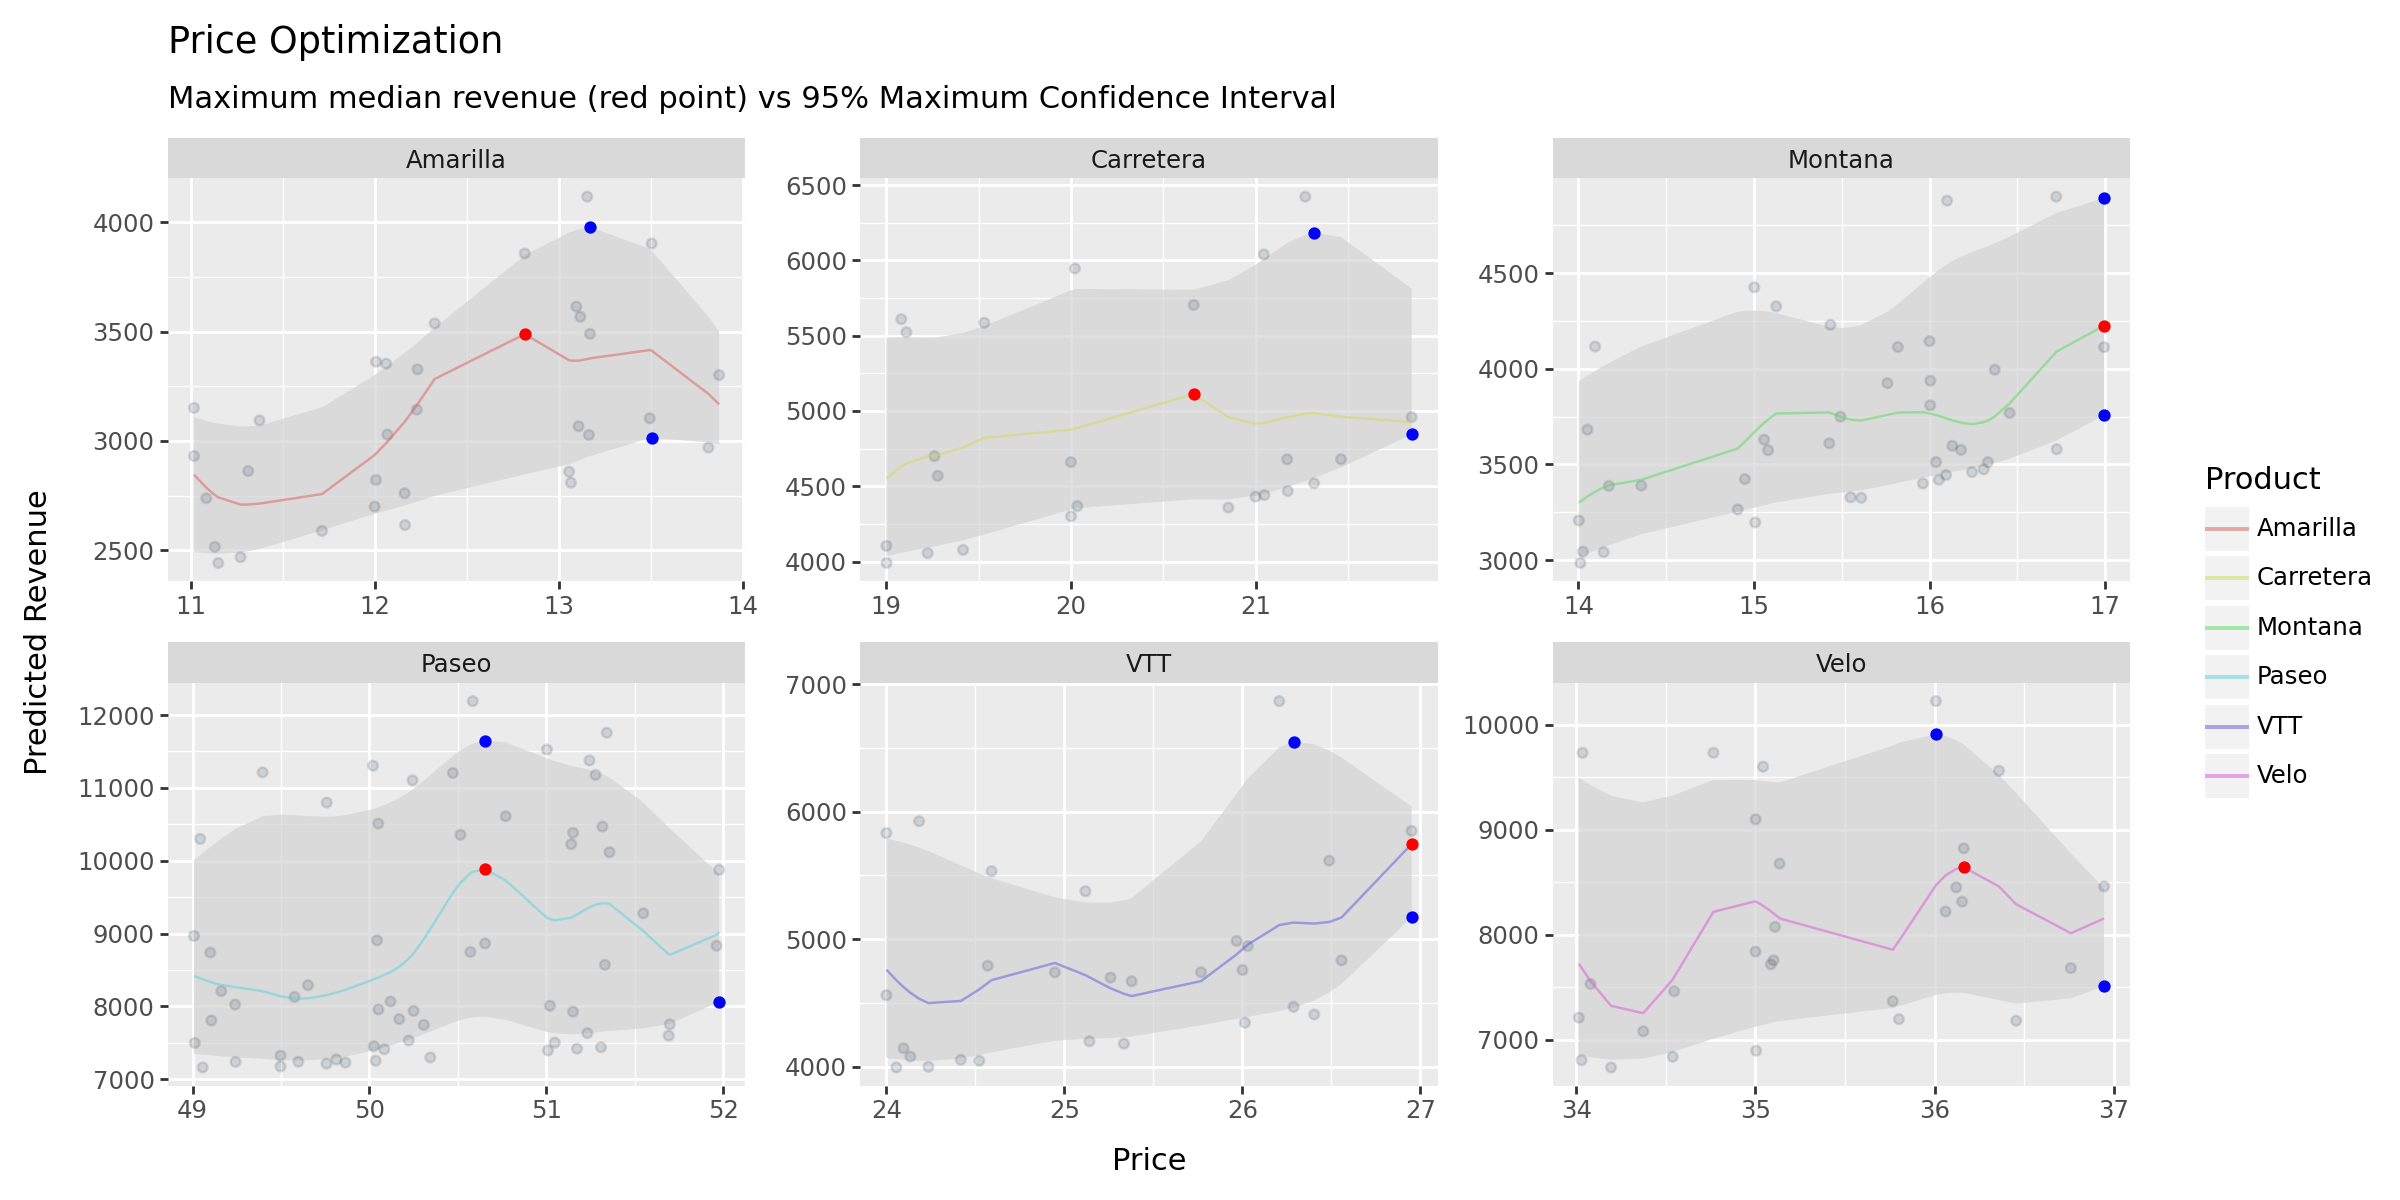

In [254]:
# Visualize the GAM Optimization Result
(ggplot(
    data = all_gam_results,
    mapping = aes(x='price', y='revenue_pred_0.5', color='Product', group='Product') ) + 
geom_ribbon(aes(ymax= 'revenue_pred_0.975', ymin= 'revenue_pred_0.025'), 
                fill='#d3d3d3', color= '#FF000000', alpha=0.7, show_legend=False) +
geom_point(aes(y='revenue_actual'), alpha=0.15, color="#2C3E50") +
geom_line(aes(y='revenue_pred_0.5'), alpha=0.5) +
geom_point(data=best_50, color='red') + 
geom_point(data=best_975, mapping= aes(y='revenue_pred_0.975'), color='blue') + 
geom_point(data=best_025, mapping= aes(y='revenue_pred_0.025'), color='blue') + 
facet_wrap('Product', scales='free') + 
labs(
    title='Price Optimization',
    subtitle='Maximum median revenue (red point) vs 95% Maximum Confidence Interval',
    x= 'Price',
    y= 'Predicted Revenue'
    ) +
theme(figure_size=(12,6))

)